<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# News Article Classification


Today, you are a machine learning engineer at [Upday](https://www.upday.com/home), a news app. The engine behind the app processes almost 100k news articles every day in many languages and context. In order to connect people with the right content, we need to know what the articles are about. 

The job here is to build a classifier that identify the category of an article accurately that will be fed into the recommendation algorithms of the app for better personalized content for the readers. 

You will first train a Transformer from scratch; then fine-tune a pre-trained Transformer model for text classification using 🤗; and compare performances using the same test data set.

## Learning objectives


By the end of this session, you will be able to:
- Understand how Transformer models work
- Build a Transformer model for text classification from scratch
- Fine-tune a pre-trained Transformer model for text classification using 🤗 

# Task 1. Prepare the data

1. [20 news groups data](http://qwone.com/~jason/20Newsgroups/) is one of the standard datasets in the `scikit-learn`. The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the two datasets is based upon messages posted before and after a specific date.

    Take a read on its [usage](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) and load the training and testing datasets into `train` and `test` respectively via `fetch_20newsgroups`.

In [1]:
NUM_LABELS = 20

In [2]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

In [3]:
print (type(train))
print (train.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [4]:
for k in train.keys():
    print (f'Name: {k}: type: {type(train[k])}, len: {len(train[k])}, example: {train[k][6]}')
    

Name: data: type: <class 'list'>, len: 11314, example: From: bmdelane@quads.uchicago.edu (brian manning delaney)
Subject: Brain Tumor Treatment (thanks)
Reply-To: bmdelane@midway.uchicago.edu
Organization: University of Chicago
Lines: 12

There were a few people who responded to my request for info on
treatment for astrocytomas through email, whom I couldn't thank
directly because of mail-bouncing probs (Sean, Debra, and Sharon).  So
I thought I'd publicly thank everyone.

Thanks! 

(I'm sure glad I accidentally hit "rn" instead of "rm" when I was
trying to delete a file last September. "Hmmm... 'News?' What's
this?"....)

-Brian

Name: filenames: type: <class 'numpy.ndarray'>, len: 11314, example: /root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58080
Name: target_names: type: <class 'list'>, len: 20, example: misc.forsale
Name: target: type: <class 'numpy.ndarray'>, len: 11314, example: 13
Name: DESCR: type: <class 'str'>, len: 10617, example: n


In [5]:
print (train.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [6]:
import numpy as np
np.unique(train.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

1. Explore the data. For example, what is the data type of `train` and `test`? What is the data type of `train['data']`? What is in `train['target_names']`? 

    YOUR ANSWER HERE
    
Both `train` and `test` are `sklearn.utils.Bunch` (something similar to dictionary). It is organized as follows:
- data [list]: contains posts (headers and bodies). Each data point is one post
- target_names [list]: contains the names of the targets (groups). There are 20 unique group names, listed in description
- target [np.ndarray]: contains classes assigned to each groups (20 classes, from 0 to 19)
- DESCR [str]: description of dataset (displayed above)


1. Train / validation / test splits. 

    There are four keys in each data set and we need "data" (the text) and "target" (the category). Extract the "data" and create a `pd.Series` named `X`; and extract the "target" and create a `pd.Series` named `y`. Do the same for the `test` data set, named `X_test` and `y_test`, respectively.

In [7]:
import pandas as pd
X, y = pd.Series(train.data), pd.Series(train.target)
X_test, y_test = pd.Series(test.data), pd.Series(test.target)

print (X.shape, y.shape)
print (X_test.shape, y_test.shape)
X.head()

(11314,) (11314,)
(7532,) (7532,)


0    From: lerxst@wam.umd.edu (where's my thing)\nS...
1    From: guykuo@carson.u.washington.edu (Guy Kuo)...
2    From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3    From: jgreen@amber (Joe Green)\nSubject: Re: W...
4    From: jcm@head-cfa.harvard.edu (Jonathan McDow...
dtype: object

In [8]:
y.head()

0     7
1     4
2     4
3     1
4    14
dtype: int64

Now split `X` and `y` into training and validation sets. Use `train_test_split` from `sklearn.model_selection` to split the data; save 10% of the data for validation and set the random state to 19.

In [9]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, 
                                                      random_state=19, 
                                                      #stratify = y
                                                     )

In [10]:
assert y_train.shape == (10182,)
assert y_valid.shape == (1132,)
assert y_test.shape == (7532,)

1. Convert categorical labels into dummy variables. 

    Use `pd.get_dummies` to convert labels into dummy variables for `y_train`, `y_valid`, `y_test`.

In [11]:
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)
y_test = pd.get_dummies(y_test)

In [12]:
assert y_train.shape == (10182, NUM_LABELS)
assert y_valid.shape == (1132, NUM_LABELS)
assert y_test.shape == (7532, NUM_LABELS)


# Task 2. Attention is all you need

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture, introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer. We now build a text classification using Attention and Positional Embeddings.

1. Transformer (attention) Block. 

    The concept of `Neural Attention` is fairly simple; i.e., not all input information seen by a model is equally important to the task at hand. Although this concept has been utilized at various different places as well, e.g., max pooling in ConvNets, but the kind of attention we are looking for should be `context aware`.

    The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other; in other words, calculate attention of all other inputs with respect to one input.

    In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces learned separately, where each subspace is called a "head". **You need to implement the multi-head attention layer**, supplying values for two parameters: `num_heads` and `key_dim`.

    There is a learnable dense projection present after the multi-head attention which enables the layer to actually learn something, as opposed to being a purely stateless transformation. **You need to implement `dense_proj`**, use the `tf.keras.Sequential` to stack two dense layers: 
    
        1. first dense layer with `dense_dim` units and activation function `relu`;
        2. second dense layer with `embed_dim` units and no activation function.

In [13]:
from tensorflow.keras import layers as L
import tensorflow as tf
from tensorflow import keras

class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            L.Dense(units=dense_dim, activation='relu'),
            L.Dense(units=embed_dim, activation=None)            
        ])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
        super().__init__(**kwargs)
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

1. Positional embedding. 

    The idea behind Positional Encoding is fairly simple as well: to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding.

    Thus, one input word embedding will have two components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.

In [14]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        self.token_embeddings = L.Embedding(input_dim = input_dim, output_dim=output_dim)
        self.position_embeddings = L.Embedding(input_dim = sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__(**kwargs)
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

1. Define some constants to parameterize the model.

In [15]:
VOCAB_SIZE = 10_000
EMBED_DIM = 256
DENSE_DIM = 32
NUM_HEADS = 2
MAX_LEN = 256

1. Tokenizer. 
    
    The tokenizer is a simple tool to convert a text into a sequence of tokens. It is used to convert the training data into a sequence of integers, which are then used as input to the model. 

    Use `Tokenizer` to create a tokenizer for the training data. Set the `num_words` parameter to the number of words to keep in the vocabulary, and `oov_token` to be `"<unk>"`.

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

1. Pad the sequences. 
    
    The tokenizer outputs a sequence of integers, which are then used as input to the model. However, the model expects a sequence of fixed length. To pad the sequences to the same length, use `sequence.pad_sequences` from `keras.preprocessing`.

    Complete function `preprocess` below to 1) tokenize the texts 2) pad the sequences to the same length.

In [17]:
from tensorflow.keras.preprocessing import sequence

def preprocess(texts, tokenizer, maxlen:int = MAX_LEN):
    seqs = tokenizer.texts_to_sequences(texts)
    tokenized_text = sequence.pad_sequences(seqs, maxlen)
    return tokenized_text

1. Preprocess the data. 
    
    Use `preprocess` to preprocess the training, validation, and test data.

In [18]:
X_train = preprocess(X_train, tokenizer)
X_valid = preprocess(X_valid, tokenizer)
X_test  = preprocess(X_test, tokenizer)

1. Define the model with the following architecture: 

    * Input Layer
    * Positional Embeddings
    * Transformer Block
    * Pooling
    * Dropout
    * Output Layer

    If you are not familiar with keras functional API, take a read [here](https://keras.io/guides/functional_api/).

In [19]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(sequence_length=MAX_LEN, input_dim=VOCAB_SIZE, output_dim=EMBED_DIM)(inputs)
x = TransformerBlock(embed_dim=EMBED_DIM, dense_dim=DENSE_DIM, num_heads=NUM_HEADS)(x)
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)


1. Compile model. 

    Use 'adam' for the optimizer and accuracy for metrics, supply the correct value for loss. 

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

1. Add [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) and [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to stop training if the model does not improve a set metric after a given number of epochs. 

    Create an `EarlyStopping` object named `es` to stop training if the validation loss does not improve after 5 epochs. Set verbose to display messages when the callback takes an action and set `restore_best_weights` to restore model weights from the epoch with the best value of the monitored metric.
    
    Use `ReduceLROnPlateau` to reduce the learning rate if the validation loss does not improve after 3 epochs. Set verbose to display messages when the callback takes an action and use default values for other parameters.
    

In [22]:
VERBOSE = 1
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=VERBOSE)
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001, verbose=VERBOSE)

1. Train the model. 
    
    Supply both `EarlyStopping` and `ReduceLROnPlateau` for `callbacks`. Set `epochs` to 100.

In [23]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    callbacks= [es, rlp],
    epochs=100
)

Epoch 1/100
319/319 [==============================] - 14s 24ms/step - loss: 3.0162 - accuracy: 0.2112 - val_loss: 1.2313 - val_accuracy: 0.6431 - lr: 0.0010
Epoch 2/100
319/319 [==============================] - 7s 23ms/step - loss: 0.9442 - accuracy: 0.7248 - val_loss: 0.5591 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 3/100
319/319 [==============================] - 7s 23ms/step - loss: 0.3883 - accuracy: 0.8836 - val_loss: 0.4826 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 4/100
319/319 [==============================] - 7s 23ms/step - loss: 0.1445 - accuracy: 0.9598 - val_loss: 0.4385 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 5/100
319/319 [==============================] - 7s 23ms/step - loss: 0.0637 - accuracy: 0.9817 - val_loss: 0.5477 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 6/100
319/319 [==============================] - 8s 24ms/step - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.5545 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 7/100
319/319 [==============================] - 8s

1. Evaluate the trained model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy will be around 0.77).

In [24]:
model.evaluate(X_test, y_test)

236/236 [==============================] - 2s 10ms/step - loss: 1.1939 - accuracy: 0.7720


[1.1938976049423218, 0.7720392942428589]

1. Visualize both loss and accuracy curves for the training and validation data. 

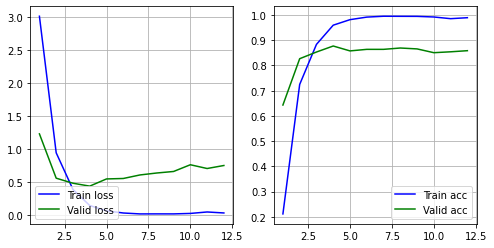

In [25]:
import matplotlib.pyplot as plt
def plot_train_valid_history(history):
    """
    Plots train and validation losses.
    Arguments: history - history of training (result of keras model.fit).
        history.history must be a dictionary that looks as follow:
        {
            'loss' : .....
            'valid_loss' : .....
            'accuracy' : .... # Optional
            'val_accuracy' : ..... # Optional
        }
    """
    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)        
        
        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right');
        plt.grid(True)        
         
        
    else:
        ax1 = fig.add_subplot(111)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)
    plt.show()


plot_train_valid_history(history)

# Task 3. Fine-tune pre-trained model via 🤗

Substantial gains can be achieved by pre-training on a large corpus of text followed by fine-tuning a specific task. In this task, we will take advantage of [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108.pdf), [`distillbert-uncased`](https://huggingface.co/distilbert-base-uncased) specifically, and fine-tune it on the 20 Newsgroups dataset.

1. Install [`Transformers`](https://huggingface.co/docs/transformers) and [`datasets`](https://huggingface.co/docs/datasets/index).

In [26]:
! pip install -U -q transformers datasets

     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 365 kB 59.3 MB/s 
     |████████████████████████████████| 6.6 MB 31.7 MB/s 
     |████████████████████████████████| 120 kB 66.9 MB/s 
     |████████████████████████████████| 115 kB 74.6 MB/s 
     |████████████████████████████████| 212 kB 71.5 MB/s 
     |████████████████████████████████| 127 kB 73.0 MB/s 


1. Import the library and check its version.


In [27]:
import transformers
print(transformers.__version__)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

4.22.0


1. Create `Dataset` objects for train / validation / test sets that are better compatible with the `Transformers` API.

    You can first create a `pd.DataFrame` with two fields: `text` and `label` with `data` and `target` from `train`. Then, call the `Dataset.from_pandas()` method to create a `Dataset` object and save it to `train_ds`. 

    Do the same for test set. 

In [28]:
from datasets import Dataset
def get_df(bunch):
  df = pd.DataFrame()
  df['text'] = bunch.data
  df['label'] = bunch.target
  return df

train_ds = Dataset.from_pandas(get_df(train))
test_ds  = Dataset.from_pandas(get_df(test))

1. Cast column `label` as `datasets.features.ClassLabel` object using [`class_encode_column`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.class_encode_column) for both `train_ds` and `test_ds`.

In [29]:
train_ds = train_ds.class_encode_column('label')
test_ds = test_ds.class_encode_column('label')
test_ds.features


Stringifying the column:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=20, names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

1. Create the validation set by apply [`train_ds.train_test_split()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split). Similarly, set the test size to 0.1, and set the random state to 19. Make sure the split is stratified by column `label`. Save the result to `train_dsd` as the result is a DatasetDict object.

    Here's another way to do train / validation / test split: [ref](https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2)

In [53]:
train_dsd = train_ds.train_test_split(test_size=0.1, seed=19, stratify_by_column="label")

In [54]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Yet the 'test' set inside `train_dsd` is meant for validation, the following code will rename the test set to validation and add a new DataSet object for the test set.

In [55]:
train_dsd['validation'] = train_dsd['test']
train_dsd['test'] = test_ds

In [56]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Load the DistilBERT tokenizer to process the text. 
    
    Use [`AutoTokenizer`](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.AutoTokenizer) to load the tokenizer for the given `model_checkpoint`. 

In [57]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

1. Create a preprocessing function to tokenize text, truncate and pad sequences to be no longer than DistilBERT’s maximum input length:

In [58]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=MAX_LEN)

1. Use 🤗 Datasets [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map) function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once:

In [59]:
tokenized_text = train_dsd.map(preprocess_function, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [60]:
tokenized_text

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

1. Use [DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding) to create a batch of examples. Set the type of Tensor to return as 'tf' as we will fine-tune the model in TensorFlow.

In [111]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

In [62]:
tokenized_text["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10182
})

1. To fine-tune a model in TensorFlow, start by converting datasets to the `tf.data.Dataset` format with `to_tf_dataset`. 

    Specify inputs and labels in columns, whether to shuffle the dataset order, batch size, and the data collator:

In [86]:
BATCH_SIZE = 16

tf_train_set = tokenized_text["train"].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols = ["labels"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
tf_validation_set = tokenized_text["validation"].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols = ["labels"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )
tf_test_set = tokenized_text["test"].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols = ["labels"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )

1. Set up an optimizer function, learning rate schedule, and some training hyperparameters:

In [139]:
from transformers import create_optimizer

EPOCHS = 5
batches_per_epoch = len(tokenized_text["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

1. Load DistilBERT with  [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels:

In [140]:
from transformers import TFAutoModelForSequenceClassification

my_bert = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=20)
my_bert.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_460', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
 dropout_460 (Dropout)       multiple                  0         
                                                                 
Total params: 66,968,852
Trainable params: 66,968,852
Non-trainable params: 0
_________________________________________________________________


1. Don't forget to configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method):

In [141]:
my_bert.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


1. Finally, let the fine-tuning start!

    You may run into CoLab's usage limit, feel free to lower the parameter `epochs` to 3; even so, it could take ~10 minutes. 

In [142]:
%%time

history = my_bert.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs=EPOCHS,
)

Epoch 1/5
637/637 [==============================] - 296s 453ms/step - loss: 2.6845 - accuracy: 0.3093 - val_loss: 1.6630 - val_accuracy: 0.5601
Epoch 2/5
637/637 [==============================] - 286s 449ms/step - loss: 1.7256 - accuracy: 0.5312 - val_loss: 1.4337 - val_accuracy: 0.6307
Epoch 3/5
637/637 [==============================] - 283s 445ms/step - loss: 2.9736 - accuracy: 0.2533 - val_loss: 1.7577 - val_accuracy: 0.3790
Epoch 4/5
637/637 [==============================] - 282s 443ms/step - loss: 1.7398 - accuracy: 0.4406 - val_loss: 1.5164 - val_accuracy: 0.5309
Epoch 5/5
637/637 [==============================] - 281s 442ms/step - loss: 1.5992 - accuracy: 0.5309 - val_loss: 1.4553 - val_accuracy: 0.5724
CPU times: user 16min 40s, sys: 28 s, total: 17min 9s
Wall time: 26min 57s


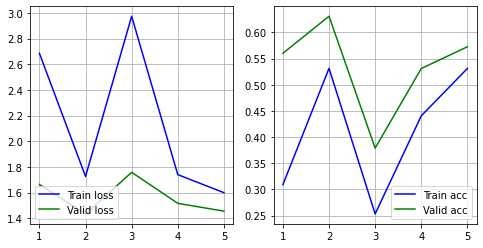

In [143]:
plot_train_valid_history(history)

In [145]:
# something weird happened in epoch 3, so let's train it again. 
# This time with a smaller learning rate.

EPOCHS = 3
total_train_steps = int(batches_per_epoch * EPOCHS)

optimizer, schedule = create_optimizer(init_lr=2e-6, num_warmup_steps=0, num_train_steps=total_train_steps)
my_bert.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = my_bert.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs=EPOCHS,
)

Epoch 1/3
637/637 [==============================] - 291s 443ms/step - loss: 1.5014 - accuracy: 0.6094 - val_loss: 1.4028 - val_accuracy: 0.6714
Epoch 2/3
637/637 [==============================] - 283s 444ms/step - loss: 1.4370 - accuracy: 0.6367 - val_loss: 1.2991 - val_accuracy: 0.6749
Epoch 3/3
637/637 [==============================] - 285s 447ms/step - loss: 1.4160 - accuracy: 0.6332 - val_loss: 1.3147 - val_accuracy: 0.6678


In [147]:
# And one more time :)

optimizer, schedule = create_optimizer(init_lr=2e-6, num_warmup_steps=0, num_train_steps=total_train_steps)
my_bert.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = my_bert.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs=EPOCHS,
)

Epoch 1/3
637/637 [==============================] - 287s 438ms/step - loss: 1.6559 - accuracy: 0.6648 - val_loss: 1.5054 - val_accuracy: 0.7005
Epoch 2/3
637/637 [==============================] - 280s 440ms/step - loss: 1.5038 - accuracy: 0.6773 - val_loss: 1.4493 - val_accuracy: 0.7005
Epoch 3/3
637/637 [==============================] - 280s 440ms/step - loss: 1.5210 - accuracy: 0.6788 - val_loss: 1.4601 - val_accuracy: 0.7058


1. As you are waiting for the fine-tuning to finish, how many parameters does DistilBERT have? How about BERT? What is the world's largest open Multilingual Language Model as of July 2022? (hint: 🌸) 

    YOUR ANSWER HERE
    
It depends on subversion, aproximately:
- DistilBert: 66M parameters
- Bert: 110M parameters
- GPT-3: 175B parameters

    

1. Evaluate the model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy shall be around 0.84).

In [148]:
bert_loss, bert_acc = my_bert.evaluate(tf_test_set) 
print (f'Accuracy: {100*bert_acc:.2f}%')

471/471 [==============================] - 72s 152ms/step - loss: 1.7260 - accuracy: 0.6795
Accuracy: 67.95%


1. Optional. If you are happy with the result, you can save the model to a file. 
    
    One easy way to do it is to use [`save_pretrained()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained) to save the model to a file. Check [Export 🤗 Transformers Models](https://huggingface.co/docs/transformers/serialization) for deployment options.

# Acknowledgement & Reference

- Part of the notebook is adapted from [Text Classification - Attention](https://www.kaggle.com/code/ritvik1909/text-classification-attention)
- Part of the notebook is adapted from [Fine-tune a pretrained model with Hugging Face](https://huggingface.co/docs/transformers/training)
- We used accuracy for metric, check out [Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd).
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0](https://medium.com/tensorflow/using-tensorflow-2-for-state-of-the-art-natural-language-processing-102445cda54a)
- More readings on Transformers, check the Course Materials section on [CS25: Transformers United](https://web.stanford.edu/class/cs25/)


# Additional Questions

### In the transformer architecture in the paper "Attention Is All You Need", how does Multi-head Attention work?
Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. Intuitively, multiple attention heads allows for attending to parts of the sequence differently (e.g. longer-term dependencies versus shorter-term dependencies). [Source](https://paperswithcode.com/method/multi-head-attention#:~:text=Multi%2Dhead%20Attention%20is%20a,transformed%20into%20the%20expected%20dimension.).


### What is the main idea behind Positional Encoding?
Positional encoding describes the location or position of an entity in a sequence so that each position is assigned a unique representation. A very good explanation is available [here](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/).

### What is EarlyStopping and why do we use it?
Early stopping is a regularization technique that prevents overfitting. The general idea is to observe the validation dataset to detect overfitting and stop training when overfitting is detected. 

### How would explain what a transformer model is to business stakeholders (at a high level)?
Transformers learn context (meaning) by tracking the relationships in sequential data (like the words in the sentence). The main difference between transformers and "classical" approaches is that transformers are also aware of the relationships (the order of the words). It increases the accuracy of the models and opens new application areas that are impossible for traditional models (e.g. one of Google Chatbots - `LaMDA` was so good that the researcher working with it claimed it is sentient).

